In [169]:
import numpy as np
import matplotlib.pyplot as plt
import opt_einsum as oe

from quant_rotor.models.dense.support_ham import write_matrix_elements, m_to_p, basis_m_to_p_matrix_conversion
from quant_rotor.models.dense.density_matrix import density_matrix_1

from quant_rotor.core.dense.hamiltonian import hamiltonian_dense

np.set_printoptions(suppress = True, linewidth = 1500, threshold = np.inf, precision = 12)

In [170]:
state = 21
site = 2
m = (state - 1) // 2

gamma = 0

D = 0.001
g = 1

# Understanding Hamiltonians

## Functions

In [ ]:
def free_one_body(i, j, max_m):

    # Free particle on a ring Hamiltonian in the momentum representation.
    # K = \sum_{m=0}^{2l} (m-l)^2 |m><m|
    if i == j:
        return (i-max_m)**2
    else:
        return 0.0

def interaction_two_body_coplanar(i1, i2, j1, j2):

    # returns <i1,i2|V|j1,j2> where V is the dipole-dipole interaction between two planar rotors oriented along the x-axis.
    # See https://arxiv.org/abs/2401.02887 for details.
    # V = 0.75 \sum_{m1, m2} (|m1, m2> <m1+1, m2+1| + |m1, m2> <m1-1, m2-1|) - 0.25 \sum_{m1, m2} (|m1, m2> <m1-1, m2+1| + |m1, m2> <m1+1, m2-1|)
    if ((abs(i1 - j1) != 1) or (abs(i2 - j2) != 1)):
        return 0.0
    elif (i1 == j1 + 1):
        if (i2 == j2 + 1):
            return 0.75
        else:
            return -0.25
    else:
        if (i2 == j2 + 1):
            return -0.25
        else:
            return 0.75

def interaction_two_body_coplanar_Test(i1, i2, j1, j2):

    # returns <i1,i2|V|j1,j2> where V is the dipole-dipole interaction between two planar rotors oriented along the x-axis.
    # See https://arxiv.org/abs/2401.02887 for details.
    # V = 0.75 \sum_{m1, m2} (|m1, m2> <m1+1, m2+1| + |m1, m2> <m1-1, m2-1|) - 0.25 \sum_{m1, m2} (|m1, m2> <m1-1, m2+1| + |m1, m2> <m1+1, m2-1|)
    if ((abs(i1 - j1) != 1) or (abs(i2 - j2) != 1)):
        return 0.0
    elif (i1 == j1 + 1):
        if (i2 == j2 + 1):
            return 0.75
        else:
            return -0.25
    else:
        if (i2 == j2 + 1):
            return -0.25
        else:
            return 0.75

def interaction_yiyj(i1, i2, j1, j2):

    # returns <i1,i2|yiyj|j1,j2> where
    # yiyj = -0.25 \sum_{m1, m2} (|m1, m2> <m1+1, m2+1| + |m1, m2> <m1-1, m2-1|) + 0.25 \sum_{m1, m2} (|m1, m2> <m1-1, m2+1| + |m1, m2> <m1+1, m2-1|)
    if ((abs(i1 - j1) != 1) or (abs(i2 - j2) != 1)):
        return 0.0
    elif (i1 - j1 == i2 - j2):
        return -0.25
    else:
        return 0.25

def interaction_xixj(i1, i2, j1, j2):

    # returns <i1,i2|xixj|j1,j2> where
    # xixj = 0.25 \sum_{m1, m2} (|m1, m2> <m1+1, m2+1| + |m1, m2> <m1-1, m2-1|) + 0.25 \sum_{m1, m2} (|m1, m2> <m1-1, m2+1| + |m1, m2> <m1+1, m2-1|)
    if ((abs(i1 - j1) != 1) or (abs(i2 - j2) != 1)):
        return 0.0
    else:
        return 0.25

In [172]:
def interaction_general_angle(i1, i2, j1, j2, tau):

    v_xi_xj = interaction_xixj(i1, i2, j1, j2)
    v_yi_yj = interaction_yiyj(i1, i2, j1, j2)

    return v_yi_yj + (1.0 - 3.0*(np.cos(tau))**2)*v_xi_xj

In [173]:
def write_matrix_elements_new(m_max, gamma):
    d = 2*m_max + 1
    K = np.zeros((d,d))
    for i in range(d):
        for j in range(i,d):
            K[i,j] = free_one_body(i, j, m_max)

    V = np.zeros((d**2, d**2))
    for i in range(d):
        for j in range(d):
            for k in range(d):
                for l in range(d):
                    # only want to write the upper triangular parts
                    # if k*d + l >= i*d + j:
                    #if hg.interaction_two_body_coplanar(i,j,k,l) != 0:
                        V[i*d + j, k*d + l] = interaction_general_angle(i,j,k,l, gamma)

    return K, V

In [174]:
def write_matrix_elements_old(m_max, gamma):
    d = 2*m_max + 1
    K = np.zeros((d,d))
    for i in range(d):
        for j in range(i,d):
            K[i,j] = free_one_body(i, j, m_max)

    V = np.zeros((d**2, d**2))
    for i in range(d):
        for j in range(d):
            for k in range(d):
                for l in range(d):
                    # only want to write the upper triangular parts
                    # if k*d + l >= i*d + j:
                    #if hg.interaction_two_body_coplanar(i,j,k,l) != 0:
                        V[i*d + j, k*d + l] = interaction_two_body_coplanar(i,j,k,l)

    return K, V

## 

In [175]:
K_o, V_o = write_matrix_elements_old((state-1)//2, gamma)
K_n, V_n = write_matrix_elements_new((state-1)//2, gamma)

In [176]:
K_o = K_o * D
K_n = K_n * D

V_o = V_o * g
V_n = V_n * g

K_o = basis_m_to_p_matrix_conversion(K_o, state)
K_n = basis_m_to_p_matrix_conversion(K_n, state)

V_o = basis_m_to_p_matrix_conversion(V_o.reshape(state, state, state, state), state).reshape(state**2, state**2)
V_n = basis_m_to_p_matrix_conversion(V_n.reshape(state, state, state, state), state).reshape(state**2, state**2)

In [177]:
H_o, K_o, V_o = hamiltonian_dense(state, site, g, Import= True, K_import=K_o, V_import=V_o, periodic=False)
H_n, K_n, V_n = hamiltonian_dense(state, site, g, Import= True, K_import=K_n, V_import=V_n, periodic=False)

In [178]:
eig_val_o, eig_vec_o = np.linalg.eigh(H_o)
eig_val_n, eig_vec_n = np.linalg.eigh(H_n)

In [179]:
print("Eig_val:", np.array_equal(eig_val_o, eig_val_n))
print("K:", np.array_equal(K_o, K_n))
print("V:", np.array_equal(V_o, V_n))

Eig_val: False
K: True
V: False


# Producing the graphs

In [180]:
D_o = density_matrix_1(state, site, eig_vec_o[:, np.argmin(eig_val_o)], 0)
D_n = density_matrix_1(state, site, eig_vec_n[:, np.argmin(eig_val_n)], 0)

In [181]:
eig_val_D_o, eig_vec_D_o = np.linalg.eigh(D_o)
eig_val_D_n, eig_vec_D_n = np.linalg.eigh(D_n)

In [ ]:
gama = np.arange(-np.pi/2, np.pi * 3/2 + 2*np.pi/100, 2*np.pi/100)

vector_in_m = np.arange(-m, m + 1)

In [300]:
index_map_m_to_p = np.vectorize(m_to_p)(vector_in_m)
index_maps = [index_map_m_to_p] * 2

D_n_in_m = D_n[np.ix_(*index_maps)]
D_o_in_m = D_o[np.ix_(*index_maps)]

In [301]:

e_plus = np.exp(1j *  np.outer(vector_in_m, gama))
e_mines = np.exp(-1j *  np.outer(vector_in_m, gama))

In [302]:
y_n = oe.contract('ap, pq, qb->ab', e_mines.T, D_n_in_m, e_plus)
y_o = oe.contract('ap, pq, qb->ab', e_mines.T, D_o_in_m, e_plus)

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


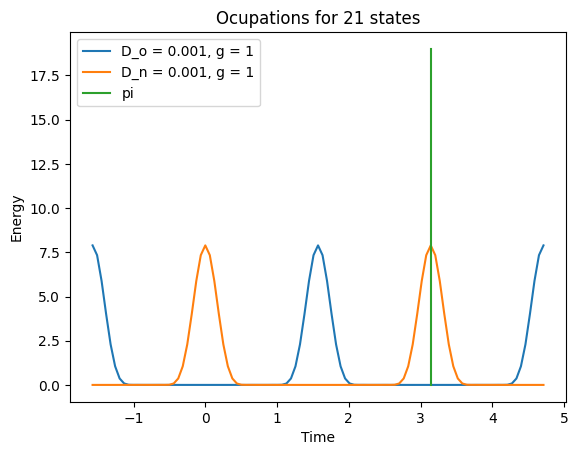

In [303]:
plt.plot(gama, np.diag(y_o), label=f"D_o = {D}, g = {g}")
plt.plot(gama, np.diag(y_n), label=f"D_n = {D}, g = {g}")
plt.plot(np.ones((20))* np.pi, np.arange(20), label=f"pi")
plt.title(f"Ocupations for {state} states")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()